In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [44]:
def get_date_list(snap_dir, start, end):
    """
    Fetch available dates by reading files
    """
    all_files = [f for f in os.listdir(snap_dir) if f.endswith('.parquet')]
    dates = sorted([f[:8] for f in all_files if start <= int(f[:8]) <= end])
    return dates

def to_seconds(ts):
    ts = ts // 1000
    return (ts // 10000) * 3600 + ((ts // 100) % 100) * 60 + (ts % 100)

def plot_sampling_analysis(symbol, date_str, event_step=19):
    snap_path = f'data/{symbol}/snap/{date_str}.parquet'
    tick_path = f'data/{symbol}/tick/{date_str}.parquet'
    
    snap_df = pd.read_parquet(snap_path)
    tick_df = pd.read_parquet(tick_path)

    snap_df = snap_df[snap_df['trade_time'] >= 93000000].copy()
    tick_df = tick_df[tick_df['trade_time'] >= 93000000].copy()

    tick_ts = tick_df['trade_time'].values
    snap_ts = snap_df['trade_time'].values
    indices = np.searchsorted(tick_ts, snap_ts)
    
    time_intervals_ticks = np.diff(indices)
    
    event_intervals_ticks = []
    event_sample_ts = []
    for i in range(0, len(snap_df) - event_step, event_step):
        cnt = indices[i + event_step] - indices[i]
        event_intervals_ticks.append(cnt)
        event_sample_ts.append(snap_df['trade_time'].iloc[i])

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    cum_ticks = np.arange(len(tick_ts))
    phys_secs = [to_seconds(t) for t in tick_ts]
    start_s = phys_secs[0]
    phys_secs = [s - start_s for s in phys_secs]
    
    ax[0].plot(phys_secs, cum_ticks, color='black', alpha=0.2, label='Market Tick Path')
    
    t_idx = np.arange(0, len(snap_ts), 10)
    t_secs = [to_seconds(snap_ts[i]) - start_s for i in t_idx]
    t_ticks = indices[t_idx]
    ax[0].scatter(t_secs, t_ticks, color='gray', s=5, label='Time Samples (3s)', alpha=0.5)
    
    e_idx = np.arange(0, len(snap_ts), event_step)
    e_secs = [to_seconds(snap_ts[i]) - start_s for i in e_idx]
    e_ticks = indices[e_idx]
    ax[0].scatter(e_secs, e_ticks, color='orange', s=20, label=f'Event Samples ({event_step} LOB Δ)', edgecolors='black', linewidth=0.5)
    
    ax[0].set_title("Sampling Points on Cumulative Tick Path")
    ax[0].set_xlabel("Seconds from Market Open")
    ax[0].set_ylabel("Cumulative Ticks (Information)")
    ax[0].legend()

    sns.violinplot(data=[time_intervals_ticks, event_intervals_ticks], ax=ax[1], palette=['#95a5a6', '#f39c12'])
    ax[1].set_xticklabels(['Time Sampling', 'Event Sampling'])
    ax[1].set_title("Information Stability per Step")
    ax[1].set_ylabel("Number of Ticks per Interval")
    
    plt.tight_layout()
    plt.show()

def plot_five_level_depth(snap_df, row_idx=500):
    row = snap_df.iloc[row_idx]
    
    bid_p = [row[f'bidprice{i}'] for i in range(5, 0, -1)]
    bid_v = [-1*row[f'bidvol{i}'] for i in range(5, 0, -1)]
    ask_p = [row[f'askprice{i}'] for i in range(1, 6)]
    ask_v = [row[f'askvol{i}'] for i in range(1, 6)]
    
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.set_facecolor('#f2f2f2')
    
    plt.bar(bid_p, bid_v, width=0.0008, color='steelblue', label='Bid', alpha=0.8)
    plt.bar(ask_p, ask_v, width=0.0008, color='darkred', label='Ask', alpha=0.8)
    
    mid_price = (bid_p[-1] + ask_p[0]) / 2
    plt.axvline(mid_price, color='black', linestyle='--', linewidth=1.5)
    plt.axhline(mid_price, color='black', linestyle='--', linewidth=1.5)
    
    # plt.annotate('Best Bid', xy=(bid_p[-1], bid_v[-1]), xytext=(bid_p[-1]-0.005, bid_v[-1]*1.3),
    #              arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6))
    # plt.annotate('Best Ask', xy=(ask_p[0], ask_v[0]), xytext=(ask_p[0]+0.003, ask_v[0]*1.3),
    #              arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6))
    
    plt.title(f"Five-Level Depth of CSI 300 ETF")
    plt.xlabel("Price")
    plt.ylabel("Volume")
    plt.legend()
    plt.show()

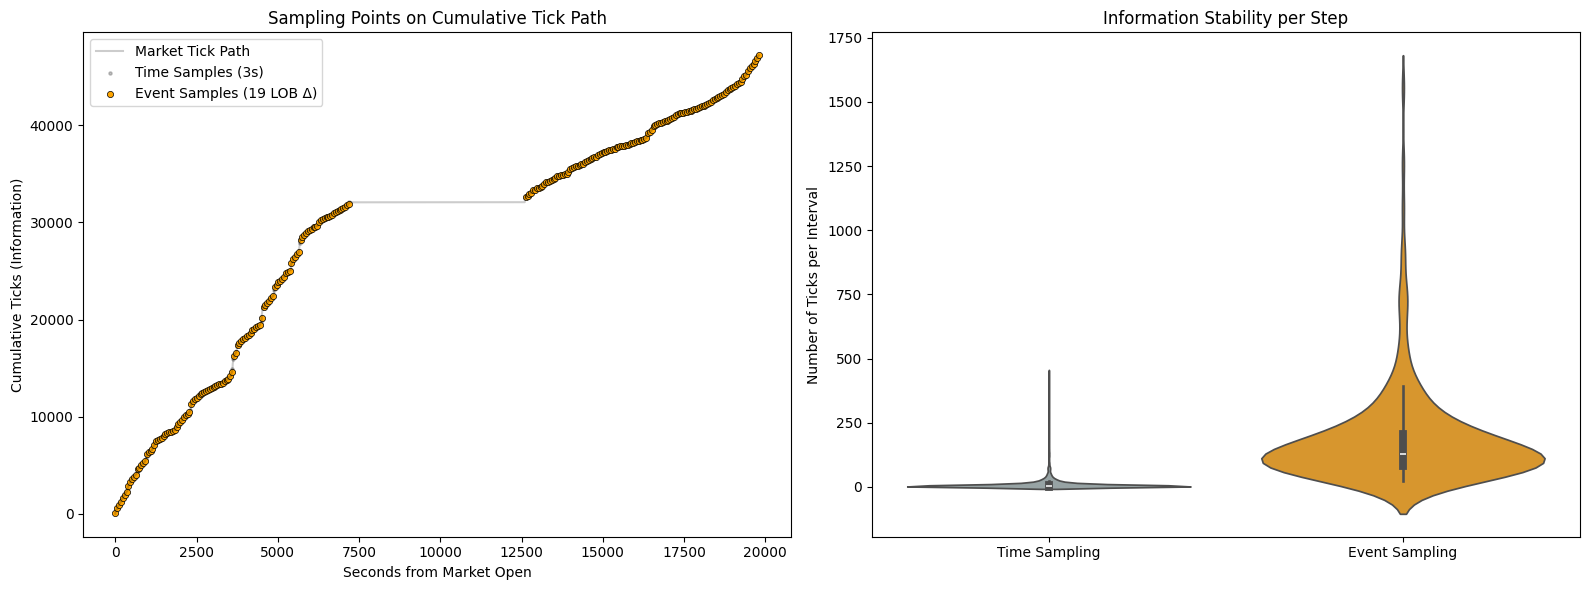

In [51]:
symbol = "510300"
date_str = "20240425"
plot_sampling_analysis(symbol, date_str, event_step=19)

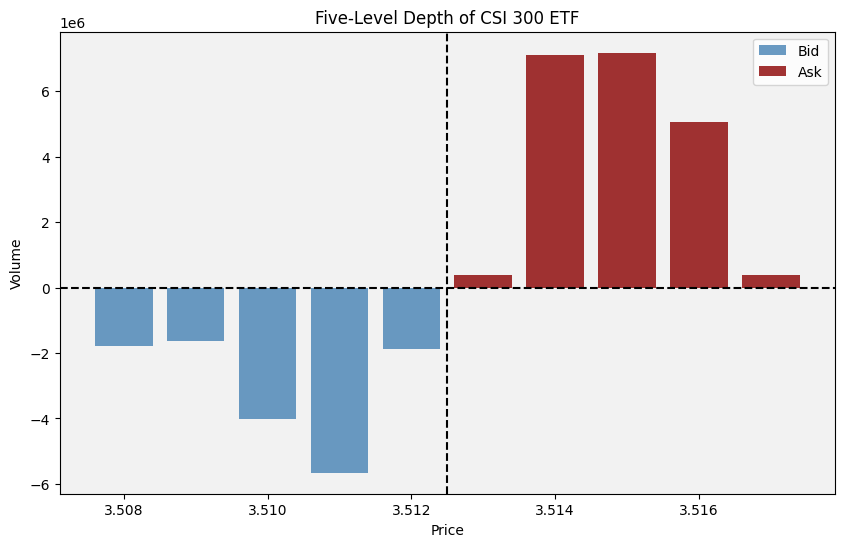

In [52]:
snap_path = f'data/{symbol}/snap/{date_str}.parquet'
snap_df = pd.read_parquet(snap_path)
plot_five_level_depth(snap_df, row_idx=1000)

In [7]:
snap_df.columns

Index(['trade_date', 'trade_time', 'trade_price', 'vol', 'amt', 'cnt',
       'cum_vol', 'cum_amt', 'high', 'low', 'open', 'pre_close', 'avg_ask',
       'avg_bid', 'total_ask', 'total_bid', 'askprice1', 'askvol1',
       'bidprice1', 'bidvol1', 'askprice2', 'askvol2', 'bidprice2', 'bidvol2',
       'askprice3', 'askvol3', 'bidprice3', 'bidvol3', 'askprice4', 'askvol4',
       'bidprice4', 'bidvol4', 'askprice5', 'askvol5', 'bidprice5', 'bidvol5',
       'askprice6', 'askvol6', 'bidprice6', 'bidvol6', 'askprice7', 'askvol7',
       'bidprice7', 'bidvol7', 'askprice8', 'askvol8', 'bidprice8', 'bidvol8',
       'askprice9', 'askvol9', 'bidprice9', 'bidvol9', 'askprice10',
       'askvol10', 'bidprice10', 'bidvol10'],
      dtype='object')